In [1]:
%matplotlib inline

In [2]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from collections import namedtuple
from itertools   import count
from copy        import deepcopy
from PIL         import Image

import torch
import torch.nn               as nn
import torch.optim            as optim
import torch.nn.functional    as F
import torchvision.transforms as T

from torch.autograd import Variable

env = gym.make('Breakout-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
use_cuda    = False # torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor  = torch.cuda.LongTensor  if use_cuda else torch.LongTensor
ByteTensor  = torch.cuda.ByteTensor  if use_cuda else torch.ByteTensor
Tensor = FloatTensor

In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Положить переход в память."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        """ Получить сэмпл из памяти """
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.cnn = nn.Sequential(
            # 84x84 | 4 -> 41x41 | 16
            nn.Conv2d(4,  16, kernel_size=4, stride=2),
            # 41x41 | 16 -> 20x20 | 32
            nn.Conv2d(16, 32, kernel_size=3, stride=2),
            # 20x20 | 32 ->  9x9 | 32
            nn.Conv2d(32, 32, kernel_size=4, stride=2),
            # 9x9 | 32 -> 3x3 | 64
            nn.Conv2d(32, 64, kernel_size=5, stride=2),
            # 3x3 | 64 -> 1x1 | 128
            nn.Conv2d(64, 128, kernel_size=3, stride=1)
        )
        
        self.sel = nn.Sequential(
            nn.Linear(128, 64),
            nn.LeakyReLU(inplace=True),
            nn.Linear(64, 32),
            nn.LeakyReLU(inplace=True),
            nn.Linear(32, 4)
        )

        self.visual_mem = []
        
    def forward(self, x):
        
        if len(self.visual_mem) < 4:
            self.visual_mem.append(x)
            return Variable(Tensor(x.size(0), 4).random_())
        else:
            self.visual_mem = self.visual_mem[1:]
            self.visual_mem.append(x)
            x = Variable(Tensor(x.size(0), 4, 84, 84))
            for i in range(4):
                x[:, i:i+1, :, :] = self.visual_mem[i]
        
        out = self.cnn(x)
        out = self.sel(out.view(out.size(0), -1))
        return out

torch.Size([1, 1, 84, 84])
torch.Size([84, 84])


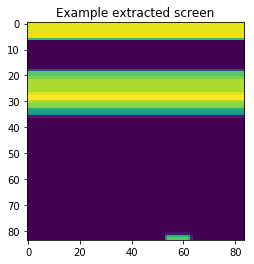

In [5]:
resize = T.Compose([T.ToPILImage(),
                    T.Grayscale(),
                    T.CenterCrop((175, 140)),
                    T.Resize((84, 84)),
                    T.ToTensor()])

def get_screen():
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))  # транспонирование в порядок торча (СHW)

    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Ресайзим и добавляем батч размерность
    if use_cuda:
        screen.cuda()
    return resize(screen).unsqueeze(0).type(Tensor)

env.reset()
plt.figure()
screen = get_screen()
print(screen.size())
screen = screen.cpu().squeeze(0).squeeze(0)
print(screen.size())

plt.imshow(screen.numpy(), interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [6]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200

model = DQN()

if use_cuda:
    model.cuda()

optimizer = optim.RMSprop(model.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        return model(
            Variable(state, volatile=True).type(FloatTensor)).data.max(1)[1].view(1, 1)
    else:
        return LongTensor([[random.randrange(4)]])


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.FloatTensor(episode_durations)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    
    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

plot_durations()

### Тренировка модели


Выбирает батчи, склеиваем тензора в один пакет, считаем $Q(s_t, a_t)$ и
$V(s_{t+1}) = \max_a Q(s_{t+1}, a)$, комбинируем их с лосом.
Устанавливаем $V(s) = 0$ if $s$ если узел терминальный.



In [7]:
last_sync = 0


def optimize_model():
    global last_sync
    if len(memory) < BATCH_SIZE:
        return
    # выбираем новый батч
    transitions = memory.sample(BATCH_SIZE)
    
    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for
    # detailed explanation).
    batch = Transition(*zip(*transitions))

    # Для всех состояний считаем маску не финальнсти и конкантенируем их
    non_final_mask = ByteTensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)))

    # Блокируем прохождение градиента для вычисления функции ценности действия
    # volatile=True
    non_final_next_states = Variable(torch.cat([s for s in batch.next_state
                                                if s is not None]),
                                     volatile=True)
    state_batch = Variable(torch.cat(batch.state))
    action_batch = Variable(torch.cat(batch.action))
    reward_batch = Variable(torch.cat(batch.reward))

    # Считаем Q(s_t, a) - модель дает Q(s_t), затем мы выбираем
    # колоки, которые соответствуют нашим действиям на щаге
    state_action_values = model(state_batch).gather(1, action_batch)

    # Подсчитываем ценность состяония V(s_{t+1}) для всех последующмх состояний.
    next_state_values = Variable(torch.zeros(BATCH_SIZE).type(Tensor))
    next_state_values[non_final_mask] = model(non_final_next_states).max(1)[0] # берем значение максимума
    
    # Для подсчета лоса нам нужно будет разрешить прохождение градиента по переменной
    # блокировку, которого мы унаследовали
    # requires_grad=False
    next_state_values.volatile = False
    # Считаем ожидаемое значение функции оценки ценности действия  Q-values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Считаем ошибку Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)

    # Оптимизация модели
    optimizer.zero_grad()
    loss.backward()
    for param in model.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

#### Тренируем модель


In [8]:
num_episodes = 5
for i_episode in range(num_episodes):
    # Инициализация среды
    env.reset()
    model.visual_mem = []
    print("Episode {0}".format(i_episode))
    
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        
        # Выбрать и выполнить нове действие
        action = select_action(state)
        _, reward, done, _ = env.step(action[0, 0])
        reward = Tensor([reward])

        # Получаем новое состояние
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Сохраняем состояние, следующее состояние, награду и действие в память
        memory.push(state, action, next_state, reward)

        # Переходим в новое состояние
        state = next_state

        # Шаг оптимизации 
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            print("Episode duration {0}".format(t + 1))
            plot_durations()
            break

print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

Episode 0


RuntimeError: inconsistent tensor size, expected tensor [128 x 1 x 84 x 84] and src [1 x 1 x 84 x 84] to have the same number of elements, but got 903168 and 7056 elements respectively at /Users/imcuber/pytorch/torch/lib/TH/generic/THTensorCopy.c:86

In [ ]:
plot_durations()